# 📽영화리뷰 텍스트 감성분석하기

# 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import tensorflow as tf
 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터로더 구성
* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # 결측치 제거
    train_data = train_data.dropna(how = 'any')  
    test_data = test_data.dropna(how = 'any') 
    
    # 토큰화, 불용어 제거
    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence)
        temp_x = [word for word in temp_x if not word in stopwords] 
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence)
        temp_x = [word for word in temp_x if not word in stopwords] 
        x_test.append(temp_x)
    
    # 사전 word_to_index 구성
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    #텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))
        
    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word={index:word for word,index in word_to_index.items()}

word_to_index['<PAD>']=0
word_to_index['<BOS>']=1
word_to_index['<UNK>']=2
word_to_index['<UNUSED>']=3

* Mecab(): NLP 필수 전처리 과정으로 형태소를 분석해줌
* Counter() : 데이터의 개수를 셀 때 유용함

In [3]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]


# encode된 벡터를 decode하여 다시 원래 텍스트 데이터로 복구하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  


# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델 구성을 위한 데이터 분석 및 가공

## 문장길이분포 & 최대 문장 길이 지정

In [4]:
total_data_text = list(x_train)+list(x_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens=np.mean(num_tokens)+2*np.std(num_tokens)
maxlen=int(max_tokens)

print('pad_sequences maXlen : ', maxlen)
print('전체 문장의 {}%가 maXlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maXlen :  41
전체 문장의 0.9342988343341575%가 maXlen 설정값 이내에 포함됩니다. 


## pre 패딩추가

In [5]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)


# 4. 모델 구성& 훈련

## 1) RNN

In [6]:
vocab_size=10000
word_vector_dim=16

# 모델구성
model=tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

#validation set 구성
x_val=x_train[:10000]
y_val = y_train[:10000]
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

#모델훈련
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

results=model.evaluate(x_test,y_test,verbose=2)
print(results)

Epoch 1/5
1064/1064 [==============================] - 10s 6ms/step - loss: 0.4095 - accuracy: 0.8185 - val_loss: 0.3387 - val_accuracy: 0.8518
Epoch 2/5
1064/1064 [==============================] - 6s 6ms/step - loss: 0.3229 - accuracy: 0.8626 - val_loss: 0.3302 - val_accuracy: 0.8551
Epoch 3/5
1064/1064 [==============================] - 6s 6ms/step - loss: 0.2963 - accuracy: 0.8749 - val_loss: 0.3276 - val_accuracy: 0.8586
Epoch 4/5
1064/1064 [==============================] - 6s 6ms/step - loss: 0.2724 - accuracy: 0.8866 - val_loss: 0.3342 - val_accuracy: 0.8560
Epoch 5/5
1064/1064 [==============================] - 6s 6ms/step - loss: 0.2525 - accuracy: 0.8957 - val_loss: 0.3462 - val_accuracy: 0.8565
1537/1537 - 3s - loss: 0.3552 - accuracy: 0.8516
[0.35524728894233704, 0.8515572547912598]


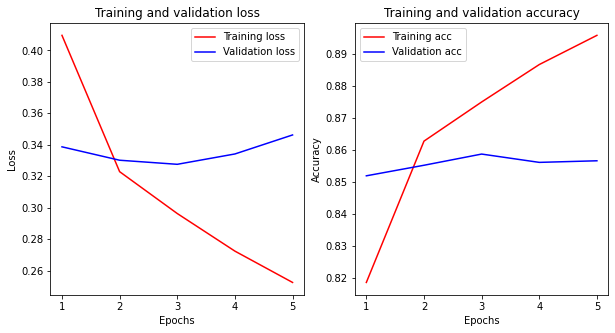

In [7]:
import matplotlib.pyplot as plt

history_dict=history.history
acc=history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs=range(1,len(acc)+1)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss,'r',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 2) CNN

In [8]:
#모델구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

#validation set 구성
x_val=x_train[:10000]
y_val = y_train[:10000]
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

#모델훈련
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

results=model.evaluate(x_test,y_test,verbose=2)
print(results)

Epoch 1/3
1064/1064 [==============================] - 7s 5ms/step - loss: 0.4005 - accuracy: 0.8133 - val_loss: 0.3278 - val_accuracy: 0.8575
Epoch 2/3
1064/1064 [==============================] - 5s 5ms/step - loss: 0.2980 - accuracy: 0.8751 - val_loss: 0.3166 - val_accuracy: 0.8636
Epoch 3/3
1064/1064 [==============================] - 5s 5ms/step - loss: 0.2499 - accuracy: 0.8994 - val_loss: 0.3277 - val_accuracy: 0.8601
1537/1537 - 3s - loss: 0.3475 - accuracy: 0.8535
[0.3474688231945038, 0.8534694910049438]


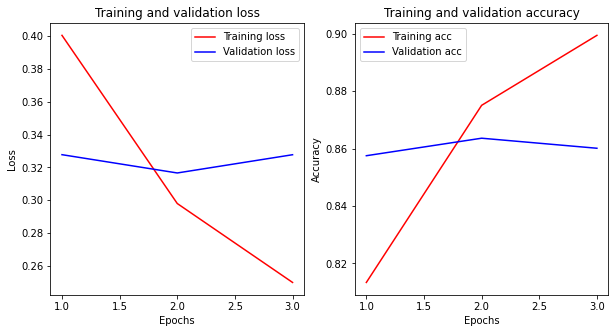

In [9]:
history_dict=history.history
acc=history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs=range(1,len(acc)+1)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss,'r',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 3) GlobalMaxPooling1D

In [10]:
# 모델구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#validation set 구성
x_val=x_train[:10000]
y_val = y_train[:10000]
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

#모델훈련
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

results=model.evaluate(x_test,y_test,verbose=2)
print(results)

Epoch 1/3
4256/4256 [==============================] - 14s 3ms/step - loss: 0.4069 - accuracy: 0.8158 - val_loss: 0.3524 - val_accuracy: 0.8424
Epoch 2/3
4256/4256 [==============================] - 14s 3ms/step - loss: 0.3235 - accuracy: 0.8615 - val_loss: 0.3476 - val_accuracy: 0.8476
Epoch 3/3
4256/4256 [==============================] - 14s 3ms/step - loss: 0.2944 - accuracy: 0.8764 - val_loss: 0.3488 - val_accuracy: 0.8498
1537/1537 - 2s - loss: 0.3622 - accuracy: 0.8447
[0.3622124195098877, 0.8446609973907471]


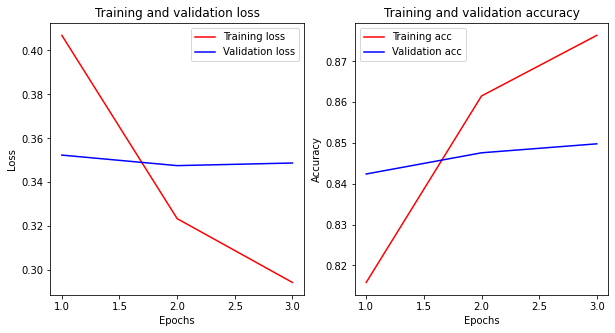

In [11]:
history_dict=history.history
acc=history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs=range(1,len(acc)+1)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss,'r',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 5. 학습된 embedding 레이어 분석

In [12]:
import os
import gensim
from tensorflow.keras.initializers import Constant
from gensim.models.keyedvectors import Word2VecKeyedVectors

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) 

(10000, 16)


In [13]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

* 학습한 임베딩 파라미터를 파일에 써서 저장한다.
* 특수 문자 4개 제외한 단어 개수만큼 워드벡터를 파일에 기록한다.

In [14]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("부산")

[('명품', 0.8925368785858154),
 ('알려', 0.8853824138641357),
 ('9', 0.8846007585525513),
 ('한지민', 0.8819237947463989),
 ('신성', 0.8806396126747131),
 ('정려원', 0.8729419112205505),
 ('탕웨이', 0.8604217767715454),
 ('자연', 0.8594315648078918),
 ('즐거움', 0.8496702909469604),
 ('쌤', 0.8480206727981567)]

* 높은 유사율과는 다르게 전혀 다른 단어들을 내뱉는것같다.
* 영어로 된 Word2Vec은 한국어를 인식을 못하는것같다.

# 6. 한국어 Word2Vec 임베딩 활용하여 성능 개선


In [15]:
gensim.__version__

'3.8.3'

In [16]:
from gensim.models import KeyedVectors

ko_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko = gensim.models.Word2Vec.load(ko_path)
ko.similar_by_word("부산")

/tmp/ipykernel_8823/1552186095.py:5: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  ko.similar_by_word("부산")


[('울산', 0.7600871920585632),
 ('광주', 0.7559570074081421),
 ('대구', 0.7386282682418823),
 ('인천', 0.684541642665863),
 ('동래구', 0.6495779156684875),
 ('창원', 0.6408145427703857),
 ('금정구', 0.6406904458999634),
 ('군산', 0.6394318342208862),
 ('수영구', 0.6326496601104736),
 ('경남', 0.6203043460845947)]

* 아까보다 낮은 유사율이지만 훨씬 유사한 단어들을 내뱉는다.

In [17]:
vocab_size = 10000   
word_vector_dim = 200 

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in ko:
        embedding_matrix[i] = ko[index_to_word[i]]

/tmp/ipykernel_8823/1052650166.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in ko:
/tmp/ipykernel_8823/1052650166.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = ko[index_to_word[i]]


## 1)RNN

In [18]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,
                                   embeddings_initializer=Constant(embedding_matrix),
                                   input_length=maxlen, trainable=True)) 
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

results=model.evaluate(x_test,y_test,verbose=2)
print(results)

Epoch 1/5
1064/1064 [==============================] - 8s 6ms/step - loss: 0.4460 - accuracy: 0.7892 - val_loss: 0.3557 - val_accuracy: 0.8439
Epoch 2/5
1064/1064 [==============================] - 6s 6ms/step - loss: 0.3321 - accuracy: 0.8582 - val_loss: 0.3387 - val_accuracy: 0.8535
Epoch 3/5
1064/1064 [==============================] - 6s 6ms/step - loss: 0.2983 - accuracy: 0.8753 - val_loss: 0.3365 - val_accuracy: 0.8558
Epoch 4/5
1064/1064 [==============================] - 6s 6ms/step - loss: 0.2751 - accuracy: 0.8865 - val_loss: 0.3376 - val_accuracy: 0.8574
Epoch 5/5
1064/1064 [==============================] - 6s 6ms/step - loss: 0.2563 - accuracy: 0.8956 - val_loss: 0.3398 - val_accuracy: 0.8574
1537/1537 - 3s - loss: 0.3523 - accuracy: 0.8507
[0.35228049755096436, 0.8507028222084045]


## 2) CNN

In [23]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,
                                    embeddings_initializer=Constant(embedding_matrix),
                                   input_length=maxlen, trainable=True)) 
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

results=model.evaluate(x_test,y_test,verbose=2)
print(results)

Epoch 1/5
4256/4256 [==============================] - 23s 5ms/step - loss: 0.4142 - accuracy: 0.8067 - val_loss: 0.3451 - val_accuracy: 0.8470
Epoch 2/5
4256/4256 [==============================] - 22s 5ms/step - loss: 0.3141 - accuracy: 0.8656 - val_loss: 0.3346 - val_accuracy: 0.8550
Epoch 3/5
4256/4256 [==============================] - 22s 5ms/step - loss: 0.2730 - accuracy: 0.8859 - val_loss: 0.3212 - val_accuracy: 0.8616
Epoch 4/5
4256/4256 [==============================] - 22s 5ms/step - loss: 0.2348 - accuracy: 0.9039 - val_loss: 0.3322 - val_accuracy: 0.8591
Epoch 5/5
4256/4256 [==============================] - 22s 5ms/step - loss: 0.1971 - accuracy: 0.9215 - val_loss: 0.3593 - val_accuracy: 0.8579
1537/1537 - 3s - loss: 0.3748 - accuracy: 0.8506
[0.37477007508277893, 0.8506214618682861]


## 3) GlobalMaxPooling1D

In [30]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,
                                   embeddings_initializer=Constant(embedding_matrix),
                                   input_length=maxlen, trainable=True)) 
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=16,
                    validation_data=(x_val, y_val),
                    verbose=1)

results=model.evaluate(x_test,y_test,verbose=2)
print(results)

Epoch 1/7
8512/8512 [==============================] - 31s 4ms/step - loss: 0.5008 - accuracy: 0.7490 - val_loss: 0.4142 - val_accuracy: 0.8107
Epoch 2/7
8512/8512 [==============================] - 30s 4ms/step - loss: 0.3856 - accuracy: 0.8270 - val_loss: 0.3776 - val_accuracy: 0.8293
Epoch 3/7
8512/8512 [==============================] - 30s 4ms/step - loss: 0.3409 - accuracy: 0.8518 - val_loss: 0.3639 - val_accuracy: 0.8334
Epoch 4/7
8512/8512 [==============================] - 30s 4ms/step - loss: 0.3090 - accuracy: 0.8693 - val_loss: 0.3755 - val_accuracy: 0.8316
Epoch 5/7
8512/8512 [==============================] - 30s 4ms/step - loss: 0.2826 - accuracy: 0.8822 - val_loss: 0.3588 - val_accuracy: 0.8433
Epoch 6/7
8512/8512 [==============================] - 31s 4ms/step - loss: 0.2601 - accuracy: 0.8942 - val_loss: 0.3677 - val_accuracy: 0.8434
Epoch 7/7
8512/8512 [==============================] - 30s 4ms/step - loss: 0.2404 - accuracy: 0.9034 - val_loss: 0.3665 - val_accuracy:

# 회고

* 한국어 임베딩을 사용하려했을때 오류가 났다. gensim을 3.8.3으로 다운그레이드하여 해결하였다.

* 솔직하게 5번부터 흐름이 어떻게 흘러가는지 모르겠다. 우리가 모델링했던 cnn,rnn 등등을 이용해서 임베딩레이어를 분석하는건가..? 전혀 상관이 없어보인다. 노드를 따라하다보니 제출을 어떻게 하긴했는데... 이부분은 조원들에게 물어봐야겠다.

* 한국어 Word2Vec을 사용해서 성능을  같은 조건하에 가시적인 성능향상을 보여주려했으나 85% 이상 달성하기가 어려워서 결국 하이퍼파라미터를 계속 조정해주었다.85% 를 넘겼으나 성능향상이 잘된건지모르겠다ㅎㅎ

* GlobalMaxPooling1D는 성능을 올리려 계속 시도했으나 실패했다. 오히려 한국어임베딩 안쓴게 더 성능이 좋다. NLP 어렵다...